## Objectives

* Have the best model set up for the ML.  

## Inputs

* Use the data processed that was collected from Kaggle `outputs/datasets/collection/AirbnbEuropeanCities.csv`. 

## Outputs

* Have the ML set up. 

---

# Change working directory 

Have the working directory changed from its current folder to its parent folder.
* We access the current directory with `os.getcwd()`.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/europe-airbnb-prices/jupyter_notebooks'

Have the parent of the current directory set up as the new current directory.
* `os.path.dirname()` gets the parent directory;
* `os.chir()` defines the new current directory.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Have the new current directory confirmed.

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/europe-airbnb-prices'

---

# Loading Data

* Have data loaded for the ML process.

In [4]:
import pandas as pd
df = pd.read_csv(f"outputs/datasets/collection/EuropeanCitiesAirbnb.csv")
df.head()

,city,bedrooms,room_type,city_center_dist_km,metro_dist_km,daily_price,weekends
0,Amsterdam,1,Private room,4.763,0.852,319.64,1
1,Amsterdam,1,Private room,5.748,3.652,348.00,1
2,Amsterdam,2,Private room,0.385,0.440,482.98,1
3,Amsterdam,1,Private room,0.545,0.319,485.55,1
4,Amsterdam,3,Entire home/apt,1.687,1.458,2771.54,1


* Have data filtered according to the analysis requirements to set up the ML.

In [5]:
cities_of_interest = ['Amsterdam', 'Barcelona', 'London']
# columns_to_include = vars_to_corr
df_filtered = df[(df['city'].isin(cities_of_interest)) & (df['room_type'] == 'Entire home/apt')]
df_filtered.head()

,city,bedrooms,room_type,city_center_dist_km,metro_dist_km,daily_price,weekends
4,Amsterdam,3,Entire home/apt,1.687,1.458,2771.54,1
5,Amsterdam,2,Entire home/apt,3.719,1.196,1001.80,1
6,Amsterdam,1,Entire home/apt,1.808,1.902,393.46,1
8,Amsterdam,1,Entire home/apt,1.010,0.917,909.47,1
10,Amsterdam,1,Entire home/apt,2.933,0.628,553.04,1


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
df_ml = df_filtered.drop(labels=['room_type'], axis=1)
print(df_ml.shape)
df_ml.head()

(6052, 6)


,city,bedrooms,city_center_dist_km,metro_dist_km,daily_price,weekends
4,Amsterdam,3,1.687,1.458,2771.54,1
5,Amsterdam,2,3.719,1.196,1001.80,1
6,Amsterdam,1,1.808,1.902,393.46,1
8,Amsterdam,1,1.010,0.917,909.47,1
10,Amsterdam,1,2.933,0.628,553.04,1


---

# Visualising the Original Distribution of `daily_price`

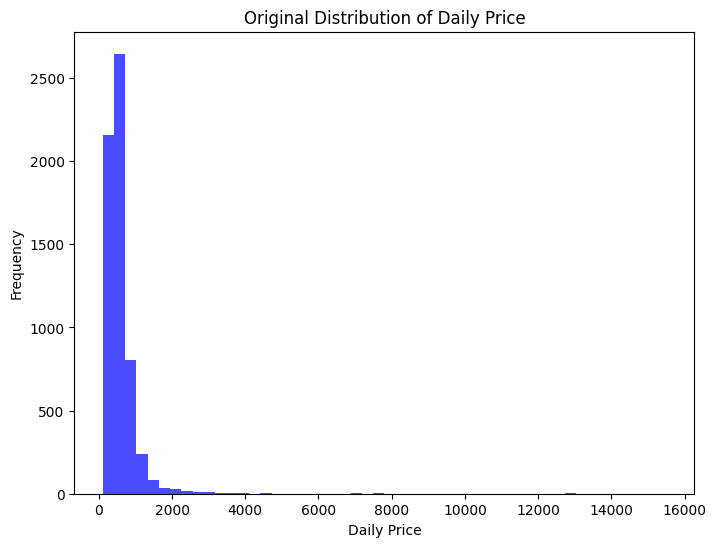

In [7]:
import matplotlib.pyplot as plt
# Visualizing the distribution of the original daily_price
plt.figure(figsize=(8, 6))
plt.hist(df_ml['daily_price'], bins=50, color='blue', alpha=0.7)
plt.title('Original Distribution of Daily Price')
plt.xlabel('Daily Price')
plt.ylabel('Frequency')
plt.show()

### Data Cleaning and Feature Engineering 

#### Preprocessing Function
Have a preprocessing pipeline created to apply the necessary transformations to the dataframe:
  + Yeo-Johnson Transformation: For numerical features `metro_dist_km` and `city_center_dist_km`;
  + One-Hot Encoding: For the categorical feature `city`;
  + Passthrough: For features that don’t require transformation, like `bedrooms`.


In [8]:
def preprocess_data():
    # Define the numerical and categorical features
    numerical_features = ['metro_dist_km', 'city_center_dist_km']
    categorical_features = ['city']
    
    # Define transformers for numerical and categorical features
    numerical_transformer = PowerTransformer(method='yeo-johnson')  # Normalize numerical features
    categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')  # One-hot encode 'city'
    
    # Combine the transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),   # Apply transformations to numerical features
            ('cat', categorical_transformer, categorical_features)  # Apply one-hot encoding to categorical features
        ],
        remainder='passthrough'  # Let 'bedrooms' pass through untransformed
    )
    
    return preprocessor

### Defining and Training  the Model

In [9]:
def check_best_pipeline(X_train, X_test, y_train, y_test):
    """
    Function to check multiple models with preprocessing and hyperparameter tuning.
    Returns the best model and results for each.
    """
    # Define the models to test
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }

    # Define the hyperparameter grids for each model
    param_grids = {
        'Linear Regression': {},  # No hyperparameters for linear regression
        'Ridge Regression': {'model__alpha': [0.1, 1.0, 10]},
        'Lasso Regression': {'model__alpha': [0.01, 0.1, 1.0]},
        'Gradient Boosting': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    }
    
    results = {}
    best_pipelines = {}  # To store the best pipeline for each model

    # Loop through each model
    for model_name, model in models.items():
        print(f"Running {model_name} with hyperparameter tuning...")
        
        # Create a pipeline for each model with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocess_data()),  # Preprocessing step
            ('model', model)  # Model step
        ])
        
        # Use GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
        
        # Fit the model with the best hyperparameters
        grid_search.fit(X_train, y_train)
        
        # Get the best model pipeline
        best_pipeline = grid_search.best_estimator_
        best_pipelines[model_name] = best_pipeline
        
        # Make predictions on the test set
        y_pred_log = best_pipeline.predict(X_test)
        y_pred = np.expm1(y_pred_log)  # Inverse log transformation
        
        # Evaluate the model
        mae = mean_absolute_error(np.expm1(y_test), y_pred)
        mse = mean_squared_error(np.expm1(y_test), y_pred)
        r2 = r2_score(np.expm1(y_test), y_pred)
        
        # Store the results, including the best hyperparameters
        results[model_name] = {
            'Best Hyperparameters': grid_search.best_params_,
            'Mean Absolute Error': mae,
            'Mean Squared Error': mse,
            'R² Score': r2
        }

    return results, best_pipelines  # Return both the results and the best pipelines


# Preparing Data 

Have the features (X) and the target variable (y) defined, and the log transformation applied to the target (daily_price) to help normalize it.

In [10]:
X = df_ml[['bedrooms', 'metro_dist_km', 'city_center_dist_km', 'city']]
y = np.log1p(df_ml['daily_price'])

Visualising the Log-Transformed `daily_price`

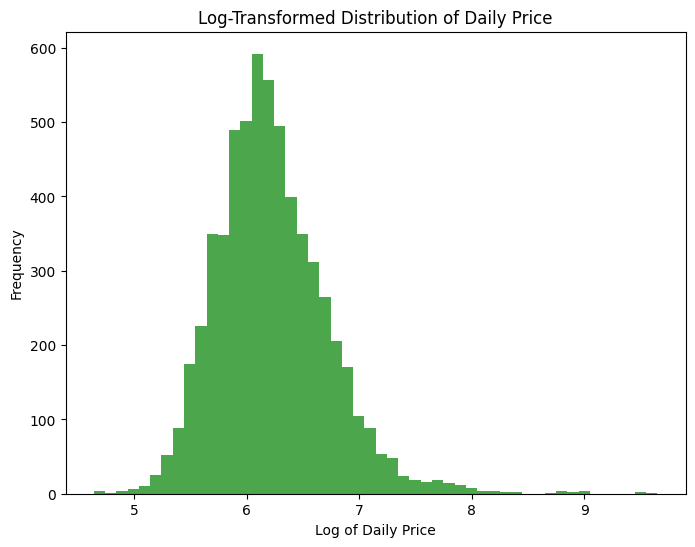

In [11]:
df_ml['log_daily_price'] = np.log1p(df_ml['daily_price'])

# Visualizing the distribution of log-transformed daily_price
plt.figure(figsize=(8, 6))
plt.hist(df_ml['log_daily_price'], bins=50, color='green', alpha=0.7)
plt.title('Log-Transformed Distribution of Daily Price')
plt.xlabel('Log of Daily Price')
plt.ylabel('Frequency')
plt.show()

Have the dataframe split into training and testing sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run the Model and Check the Best Pipeline

Have the `check_best_pipeline()` function run to check which model performs the best.

In [13]:
# Run the function to try multiple models with hyperparameter tuning
results, best_pipelines = check_best_pipeline(X_train, X_test, y_train, y_test)

# Display the results for each model
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    print(f"Best Hyperparameters: {metrics['Best Hyperparameters']}")
    print(f"Mean Absolute Error: {metrics['Mean Absolute Error']}")
    print(f"Mean Squared Error: {metrics['Mean Squared Error']}")
    print(f"R² Score: {metrics['R² Score']}")
    print('-' * 50)

Running Linear Regression with hyperparameter tuning...


Running Ridge Regression with hyperparameter tuning...
Running Lasso Regression with hyperparameter tuning...
Running Gradient Boosting with hyperparameter tuning...
Results for Linear Regression:
Best Hyperparameters: {}
Mean Absolute Error: 180.8657140823323
Mean Squared Error: 277305.2703095128
R² Score: 0.13996666335587604
--------------------------------------------------
Results for Ridge Regression:
Best Hyperparameters: {'model__alpha': 10}
Mean Absolute Error: 180.87045388099307
Mean Squared Error: 277397.3533590115
R² Score: 0.13968107739416558
--------------------------------------------------
Results for Lasso Regression:
Best Hyperparameters: {'model__alpha': 0.01}
Mean Absolute Error: 183.27262213696747
Mean Squared Error: 279944.6409884673
R² Score: 0.13178093082678166
--------------------------------------------------
Results for Gradient Boosting:
Best Hyperparameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300}
Mean Absolute Error:

### Analysing Feature Importance

Accessing the best Gradient Boosting pipeline...


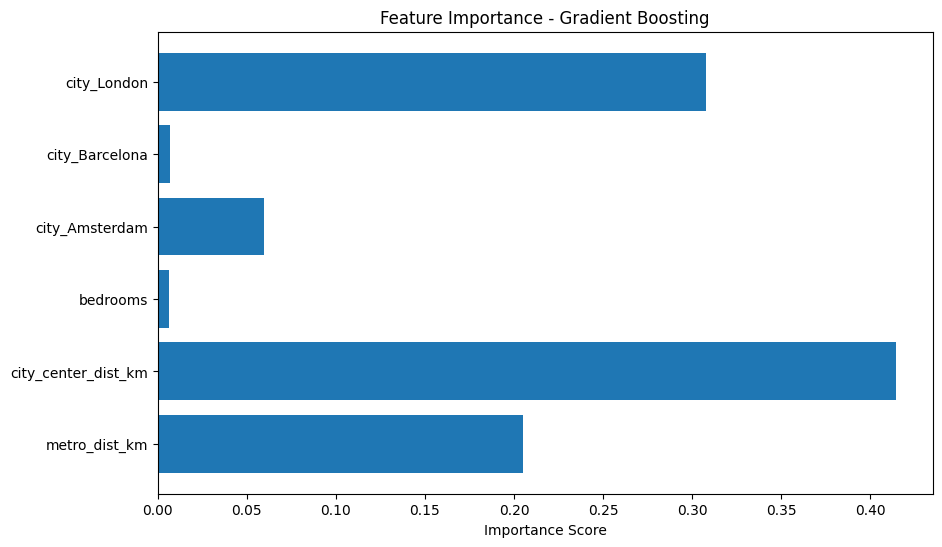

In [14]:
best_gb_pipeline = best_pipelines.get('Gradient Boosting')

if best_gb_pipeline:
    print("Accessing the best Gradient Boosting pipeline...")

    # Access the fitted Gradient Boosting model inside the pipeline
    best_gb_model = best_gb_pipeline.named_steps['model']
    
    # Check feature importance
    importances = best_gb_model.feature_importances_
    
    # Get the feature names (for numerical + one-hot encoded city variables)
    city_feature_names = list(best_gb_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(['city']))
    feature_names = ['metro_dist_km', 'city_center_dist_km', 'bedrooms'] + city_feature_names
    
    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances)
    plt.title('Feature Importance - Gradient Boosting')
    plt.xlabel('Importance Score')
    plt.show()


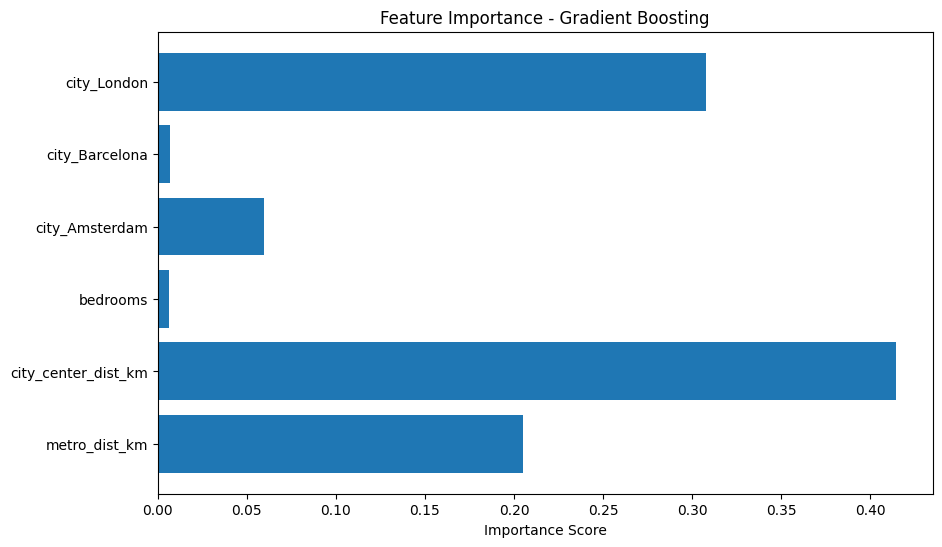

Mean Absolute Error (Final Model): 113.20310794095712
Mean Squared Error (Final Model): 87731.56622364257
R² Score (Final Model): 0.727909709238058


In [15]:
# Finalize the Gradient Boosting Model (best model from hyperparameter tuning)
best_gb_pipeline = best_pipelines.get('Gradient Boosting')

# Accessing the best Gradient Boosting model inside the pipeline
best_gb_model = best_gb_pipeline.named_steps['model']

# Feature Importance Analysis
importances = best_gb_model.feature_importances_

# Get the feature names (for numerical + one-hot encoded city variables)
city_feature_names = list(best_gb_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(['city']))
feature_names = ['metro_dist_km', 'city_center_dist_km', 'bedrooms'] + city_feature_names

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Importance Score')
plt.show()

# Make final predictions using the best Gradient Boosting pipeline
y_pred_log = best_gb_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  

# Evaluate the final model
mae = mean_absolute_error(np.expm1(y_test), y_pred)
mse = mean_squared_error(np.expm1(y_test), y_pred)
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"Mean Absolute Error (Final Model): {mae}")
print(f"Mean Squared Error (Final Model): {mse}")
print(f"R² Score (Final Model): {r2}")


# Pushing File to Repo

In [16]:
import joblib
import os
import matplotlib.pyplot as plt

# Specify version and file path
version = 'v1'
file_path = f'outputs/ml_pipeline/airbnb_price_prediction/{version}'

# Create the directory if it doesn't exist
try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)


In [17]:
# Save the final Gradient Boosting pipeline
joblib.dump(value=best_gb_pipeline, filename=f"{file_path}/price_prediction_pipeline.pkl")

['outputs/ml_pipeline/airbnb_price_prediction/v1/price_prediction_pipeline.pkl']

In [18]:
df_ml.to_csv(f"{file_path}/TrainSet.csv", index=False)

In [20]:
# Save the feature importance plot
importances = best_gb_model.feature_importances_
city_feature_names = list(best_gb_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(['city']))
feature_names = ['metro_dist_km', 'city_center_dist_km', 'bedrooms'] + city_feature_names

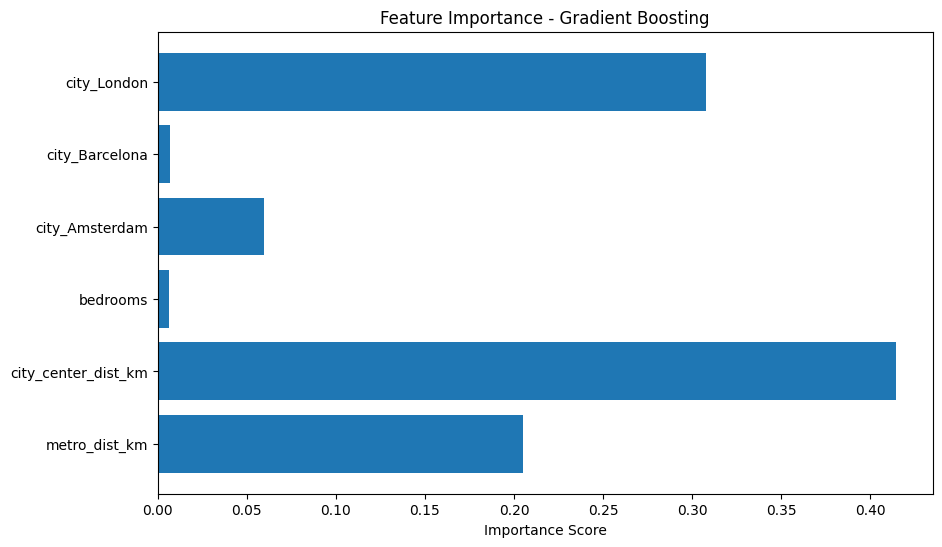

In [21]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Importance Score')
plt.savefig(f"{file_path}/feature_importance.png", bbox_inches='tight', dpi=150)
plt.show()

In [22]:
# Save the performance metrics (MAE, MSE, R²)
mae = mean_absolute_error(np.expm1(y_test), y_pred)
mse = mean_squared_error(np.expm1(y_test), y_pred)
r2 = r2_score(np.expm1(y_test), y_pred)

In [23]:
# Save the results in a CSV
with open(f"{file_path}/model_performance.csv", 'w') as f:
    f.write('Metric,Value\n')
    f.write(f'Mean Absolute Error,{mae}\n')
    f.write(f'Mean Squared Error,{mse}\n')
    f.write(f'R² Score,{r2}\n')

print("Files saved successfully.")

Files saved successfully.
